# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**: Fenya Bartram

**ID**: fdb34

> **Due Date**
>
> Thursday, 11/07/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\fenya\Documents\BEE4750\Project`
    Updating registry at `C:\Users\fenya\.julia\registries\General.toml`
   Installed HiGHS_jll ──────────── v1.8.0+0
   Installed CommonSubexpressions ─ v0.3.1
   Installed MutableArithmetics ─── v1.5.2
   Installed CodecBzip2 ─────────── v0.8.4
   Installed HTTP ───────────────── v1.10.10
   Installed ColorVectorSpace ───── v0.11.0
   Installed JuMP ───────────────── v1.23.4
   Installed HiGHS ──────────────── v1.12.0
   Installed ColorSchemes ───────── v3.27.1
   Installed ForwardDiff ────────── v0.10.38
   Installed MathOptInterface ───── v1.34.0
    Updating `C:\Users\fenya\Documents\BEE4750\Project\Project.toml`
  [336ed68f] + CSV v0.10.15
  [a93c6f00] + DataFrames v1.7.0
  [87dc4568] + HiGHS v1.12.0
  [4076af6c] + JuMP v1.23.4
  [1862ce21] + MarkdownTables v1.1.0
  [442fdcdd] + Measures v0.3.2
  [86f7a689] + NamedArrays v0.10.3
  [91a5bcdd] + Plots v1.40.8
    Updating `C:\Users\fenya\Documents\BEE4750\Project\Ma

In [2]:
# import Pkg; Pkg.add("NamedArrays")

In [24]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables
using NamedArrays
using Dates

### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

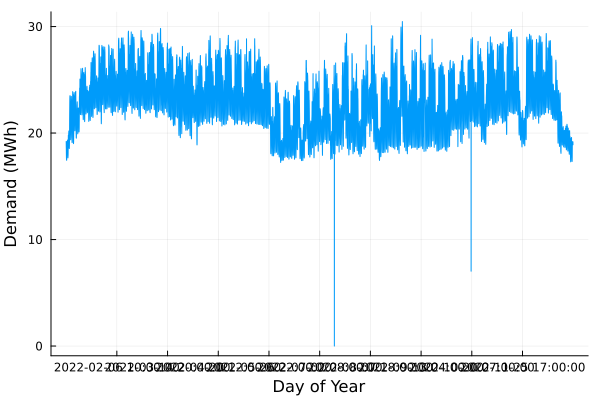

In [9]:
# load the data, pull Zone C, and reformat the DataFrame
CU_edemand = DataFrame(CSV.File("data/Cornell_Electricity_Data.csv"))
rename!(CU_edemand, :"slottime_GMT" => :Date)
edemand = CU_edemand[:, [:Date, :slotavg]]
rename!(edemand, :slotavg => :edemand)
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(edemand.Date, edemand.edemand, xlabel="Day of Year", ylabel="Demand (MWh)", label=:false)

In [88]:
[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]

8736-element Vector{DateTime}:
 2022-01-01T00:00:00
 2022-01-01T01:00:00
 2022-01-01T02:00:00
 2022-01-01T03:00:00
 2022-01-01T04:00:00
 2022-01-01T05:00:00
 2022-01-01T06:00:00
 2022-01-01T07:00:00
 2022-01-01T08:00:00
 2022-01-01T09:00:00
 ⋮
 2022-12-31T15:00:00
 2022-12-31T16:00:00
 2022-12-31T17:00:00
 2022-12-31T18:00:00
 2022-12-31T19:00:00
 2022-12-31T20:00:00
 2022-12-31T21:00:00
 2022-12-31T22:00:00
 2022-12-31T23:00:00

In [51]:
transform(edemand, :Date => (ByRow(t -> Dates.DateTime(t, dateformat"yyyy-mm-dd HH:MM:SS"))) => :Date)

Row,Date,edemand
,DateTime,Float64
1,2022-01-01T00:00:00,19.2144
2,2022-01-01T01:00:00,18.705
3,2022-01-01T02:00:00,18.5034
4,2022-01-01T03:00:00,18.0225
5,2022-01-01T04:00:00,17.6864
6,2022-01-01T05:00:00,17.6017
7,2022-01-01T06:00:00,17.4555
8,2022-01-01T07:00:00,17.6025
9,2022-01-01T08:00:00,17.4436


In [123]:
e_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)])

24-element Vector{DateTime}:
 2022-01-19T15:00:00
 2022-03-16T21:00:00
 2022-03-16T22:00:00
 2022-03-16T23:00:00
 2022-03-17T00:00:00
 2022-03-17T01:00:00
 2022-03-17T02:00:00
 2022-09-15T18:00:00
 2022-09-15T19:00:00
 2022-09-15T20:00:00
 ⋮
 2022-09-16T02:00:00
 2022-09-16T03:00:00
 2022-09-16T04:00:00
 2022-09-16T05:00:00
 2022-09-16T06:00:00
 2022-09-16T07:00:00
 2022-09-16T08:00:00
 2022-09-16T09:00:00
 2022-09-16T10:00:00

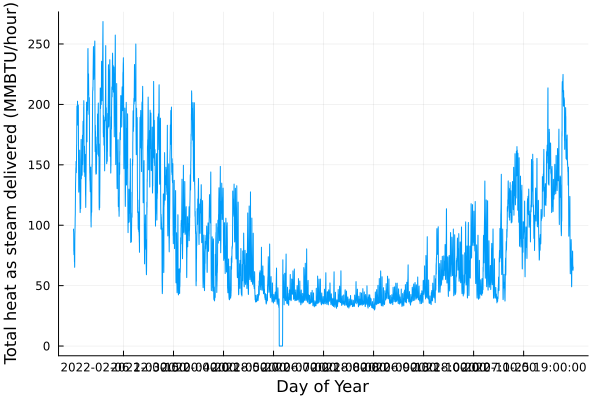

In [98]:
# load the data, pull Zone C, and reformat the DataFrame
CU_hdemand = DataFrame(CSV.File("data/Cornell_steam_data.csv"))
rename!(CU_hdemand, :"slottime_GMT" => :Date)
hdemand = CU_hdemand[:, [:Date, :slotavg]]
rename!(hdemand, :slotavg => :hdemand)

# Converting to units of MMBTU of heat produced (before distribution losses)
hdemand.hdemand = hdemand.hdemand*0.001194
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(hdemand.Date, hdemand.hdemand, xlabel="Day of Year", ylabel="Total heat as steam delivered (MMBTU/hour)", label=:false)

In [122]:
h_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(hdemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(hdemand.Date)])

8-element Vector{DateTime}:
 2022-01-19T15:00:00
 2022-03-16T21:00:00
 2022-03-16T22:00:00
 2022-03-16T23:00:00
 2022-03-17T00:00:00
 2022-03-17T01:00:00
 2022-03-17T02:00:00
 2022-09-15T18:00:00

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [272]:
# Electricity production conversion (MWh/MMBtu), assumed constant
ratio = 0.300490591
gens = DataFrame(CSV.File("data/Gen_data_CU.csv"))

Row,Column1,Capacity,VarCost,Emissions
,String7,Int64,Float64,Float64
1,NG,30,27.5345,0.575831
2,Solar,28,0.0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

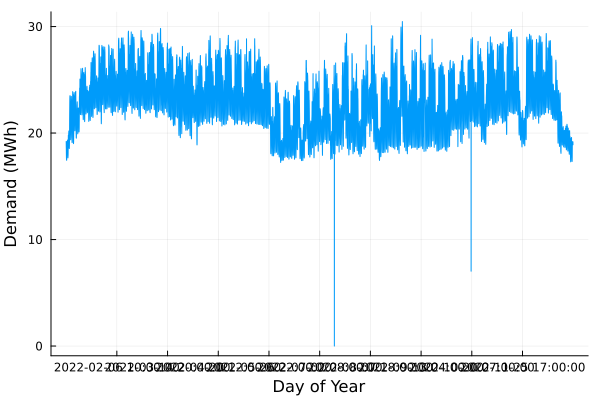

In [ ]:
# load the data, pull Zone C, and reformat the DataFrame
CU_edemand = DataFrame(CSV.File("data/Cornell_Electricity_Data.csv"))
rename!(CU_edemand, :"slottime_GMT" => :Date)
edemand = CU_edemand[:, [:Date, :slotavg]]
rename!(edemand, :slotavg => :edemand)
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(edemand.Date, edemand.edemand, xlabel="Day of Year", ylabel="Demand (MWh)", label=:false)

In [ ]:
[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]

8736-element Vector{DateTime}:
 2022-01-01T00:00:00
 2022-01-01T01:00:00
 2022-01-01T02:00:00
 2022-01-01T03:00:00
 2022-01-01T04:00:00
 2022-01-01T05:00:00
 2022-01-01T06:00:00
 2022-01-01T07:00:00
 2022-01-01T08:00:00
 2022-01-01T09:00:00
 ⋮
 2022-12-31T15:00:00
 2022-12-31T16:00:00
 2022-12-31T17:00:00
 2022-12-31T18:00:00
 2022-12-31T19:00:00
 2022-12-31T20:00:00
 2022-12-31T21:00:00
 2022-12-31T22:00:00
 2022-12-31T23:00:00

In [ ]:
transform(edemand, :Date => (ByRow(t -> Dates.DateTime(t, dateformat"yyyy-mm-dd HH:MM:SS"))) => :Date)

Row,Date,edemand
,DateTime,Float64
1,2022-01-01T00:00:00,19.2144
2,2022-01-01T01:00:00,18.705
3,2022-01-01T02:00:00,18.5034
4,2022-01-01T03:00:00,18.0225
5,2022-01-01T04:00:00,17.6864
6,2022-01-01T05:00:00,17.6017
7,2022-01-01T06:00:00,17.4555
8,2022-01-01T07:00:00,17.6025
9,2022-01-01T08:00:00,17.4436


In [ ]:
e_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)])

24-element Vector{DateTime}:
 2022-01-19T15:00:00
 2022-03-16T21:00:00
 2022-03-16T22:00:00
 2022-03-16T23:00:00
 2022-03-17T00:00:00
 2022-03-17T01:00:00
 2022-03-17T02:00:00
 2022-09-15T18:00:00
 2022-09-15T19:00:00
 2022-09-15T20:00:00
 ⋮
 2022-09-16T02:00:00
 2022-09-16T03:00:00
 2022-09-16T04:00:00
 2022-09-16T05:00:00
 2022-09-16T06:00:00
 2022-09-16T07:00:00
 2022-09-16T08:00:00
 2022-09-16T09:00:00
 2022-09-16T10:00:00

In [ ]:
cap_factor = DataFrame(CSV.File("data/2022_solar_CF_zone_C.csv", header=4))
cap_factor=  cap_factor[:, [:time, :electricity]]
rename!(cap_factor, :electricity => :Solar)
missing_dates = [h_missing_dates; e_missing_dates]
e_dts = [Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]
h_dts = [Dates.DateTime(hdemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(hdemand.Date)]
cf_dts = [Dates.DateTime(cap_factor.time[i], dateformat"mm/dd/yyyy HH:MM") for i in 1:length(cap_factor.time)]
cap_factor = cap_factor[[cf_dts[i] ∉ missing_dates for i in 1:length(cap_factor.time)],:]
edemand = edemand[[e_dts[i] ∉ missing_dates for i in 1:length(edemand.Date)],:]
hdemand = hdemand[[h_dts[i] ∉ missing_dates for i in 1:length(hdemand.Date)],:]

Row,time,Solar
,String31,Float64
1,1/1/2022 0:00,0.0
2,1/1/2022 1:00,0.0
3,1/1/2022 2:00,0.0
4,1/1/2022 3:00,0.0
5,1/1/2022 4:00,0.0
6,1/1/2022 5:00,0.0
7,1/1/2022 6:00,0.0
8,1/1/2022 7:00,0.0
9,1/1/2022 8:00,0.0


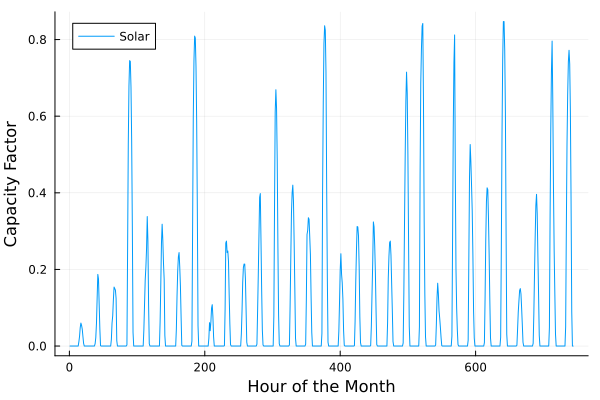

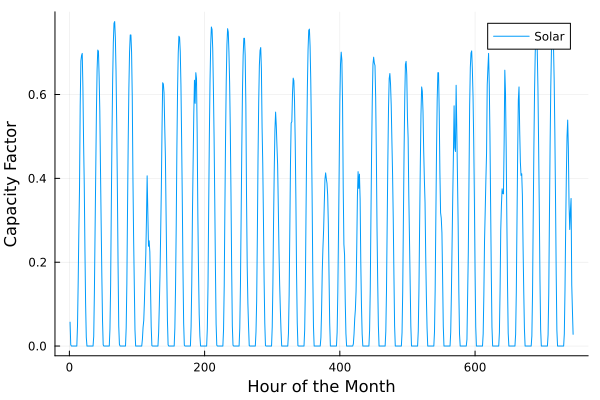

In [119]:
cap_factor = DataFrame(CSV.File("data/2022_solar_CF_zone_C.csv", header=4))
cap_factor=  cap_factor[:, [:time, :electricity]]
rename!(cap_factor, :electricity => :Solar)

# plot January capacity factors
# p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
p1 = plot(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

# p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
p2 = plot(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

## Solutions

Base case capacity expansion (no heating)

Decision variables:
$x_{g}$ = Installed capacity for generator type g (MW)

$y_{g,t}$ = Production from generator g in time t (MWh)

$NSE_{t}$ = non-served energy in time t (MWh)

Minimize total cost = fixed cost + variable cost + unserved energy cost
\begin{align}
\min_{x, y, NSE} \quad & \sum_{g \in \mathcal{G}} \text{FixedCost}_g \times x_g + \sum_{t \in \mathcal{T}} \sum_{g \in \mathcal{G}} \text{VarCost}_g \times y_{g,t} & \\
& \quad + \sum_{t \in \mathcal{T}} \text{NSECost} \times NSE_t & \\[0.5em]
\text {subject to:} \quad & \sum_{g \in \mathcal{G}} y_{g,t} + NSE_t \geq d_t \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting demand in each hour)} \\
& y_{g,t} \leq x_g*c_{g,t} \qquad \qquad \qquad\qquad  \forall g \in {G},  \forall t \in \mathcal{T} \\[0.5em]
\text{(Generator capacity limits)} \\
& x_g, y_{g,t}, NSE_t \geq 0 \qquad \qquad \forall g \in {G},  \forall t \in \mathcal{T}
\end{align}

Economic Dispatch with CHP

Decision variables:

$y_{g,t}$ = Production from generator g in time t (MWh)

$z_{s,t}$ = Heat production from source s in time t (MWh)

$NSE_{t}$ = non-served energy in time t (MWh)

Parameters:

r = Conversion factor for CHP, MWh produced per MMBTU produced

$c_{hp,t}$ = Conversion factor for heat pump, MWh required per MMBTU produced


Minimize total cost = fixed cost + variable cost + unserved energy cost
\begin{align}
\sum_{t \in \mathcal{T}} \sum_{g \in \mathcal{G}} \text{VarCost}_g \times y_{g,t} \quad + \sum_{t \in \mathcal{T}} \text{NSECost} \times NSE_t & \\[0.5em]
\text {subject to:} \quad & \sum_{g \in \mathcal{G}} y_{g,t} + NSE_t \geq d_t + c_{hp,t}* z_{hp,t} \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting demand in each hour)} \\
\quad & \sum_{s \in \mathcal{S}} h_{s,t} \geq zd_t \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting heating demand in each hour)} \\
\quad & z_{n,t} = r*y_{n,t} \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Assume constant ratio of heat to electricty production from natural gas)} \\
& y_{g,t} \leq x_g*c_{g,t} \qquad \qquad \qquad\qquad  \forall g \in {G},  \forall t \in \mathcal{T} \\[0.5em]
\text{(Generator capacity limits)} \\
& x_g, y_{g,t}, NSE_t \geq 0 \qquad \qquad \forall g \in {G},  \forall t \in \mathcal{T}
\end{align}

-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?

| Type | Capacity (MW) |
|:------------------------:|:---------------:|
|            Geothermal             |       0      |  
|                Coal         |      0      |   
|            NG CCGT             |      1658.45   |   
|            NG CT            |      879.75   |  
|            Wind           |      484.95   | 
|           Solar          |      1957.64   |

Total cost = $654.58 M

Nonserved load = 256.83 MWh

-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?

| Type | Percent Capacity | Percent Annual Generation |
|:------------------------:|:---------------:| :---------------:|
|            Geothermal             |       0%      |         0%      | 
|                Coal         |      0%      |          0%      | 
|            NG CCGT             |      33.30%   |          52.89%      | 
|            NG CT            |      17.66%  |         2.74%      | 
|            Wind           |      9.74%   |        8.72%      | 
|           Solar          |      39.30%   |       35.65%      | 

There results do make sense. NG CCGTs, with their relatively high capacity factor, produce over 50% of total power, despite being only 33.3% of installed capacity. While NG CTs can function at high capacity factors, due to their high variable cost they tend to act as peaker plants, used to meet demand during times when it is at its maximum (and when wind and solar generation are low). Thus, it makes sense that such plants make up only a small percent of total generation. Because wind and solar have lower capacity factors compared to gas due to their weather dependence, they make up a slightly smaller portion of generation than they do of capacity.


-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

The electricity price is highly peaked. A few times throughout the year, the price spikes to $1000/MWh, during periods with unserved load. Higher prices occur during the beginning and end of the year, corresponding to winter hours when solar resources are poor, and electricity demand is relatively high due to increased lighting and heating requirements (in the case of heat pumps or resistive heating). The prices are also higher during the summer time (around hours 4000-6000), corresponding to peak electricity demand during this season. During the spring and fall, when temperatures are less extreme, the prices are lower due to lower electricity demand for climate control.


In [200]:
cap_factor[:, :Gas] .=1
# cap_factor[:, :Geothermal] .=0.8
# cap_factor[:, :NG_CCGT] .=1
# cap_factor[:, :NG_CT] .=1
select!(cap_factor, :Gas, :Solar)

Row,Gas,Solar
,Int64,Float64
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0
5,1,0.0
6,1,0.0
7,1,0.0
8,1,0.0
9,1,0.0


In [184]:
# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

(2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:8736
And data, a 2×8736 Matrix{VariableRef}:
 y[1,1]  y[1,2]  y[1,3]  y[1,4]  y[1,5]  …  y[1,8734]  y[1,8735]  y[1,8736]
 y[2,1]  y[2,2]  y[2,3]  y[2,4]  y[2,5]     y[2,8734]  y[2,8735]  y[2,8736], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{VariableRef}:
 NSE[1]
 NSE[2]
 NSE[3]
 NSE[4]
 NSE[5]
 NSE[6]
 NSE[7]
 NSE[8]
 NSE[9]
 NSE[10]
 ⋮
 NSE[8728]
 NSE[8729]
 NSE[8730]
 NSE[8731]
 NSE[8732]
 NSE[8733]
 NSE[8734]
 NSE[8735]
 NSE[8736])

In [216]:
# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)

@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)



Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [3e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [3e-02, 3e+01]
Presolving model
8735 rows, 17470 cols, 17470 nonzeros  0s
8694 rows, 17388 cols, 17388 nonzeros  0s
Presolve : Reductions: rows 8694(-17514); columns 17388(-8820); elements 17388(-26292)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8694(162591) 0s
       8694     4.4768782365e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 8694
Objective value     :  4.4768782365e+06
HiGHS run time      :          0.33


In [ ]:
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:outerright, legendcolumns=1)
plot!(p, size=(1200, 500))

In [247]:
heat = gens[1,:]

Row,Column1,Capacity,VarCost,Emissions
,String7,Int64,Float64,Float64
1,NG,30,27.5345,0.575831


In [271]:
sum(hdemand.hdemand)

758358.161053973

In [275]:
sum(hdemand.hdemand.*ratio)

227879.49200478152

In [276]:
sum(edemand.edemand)

202154.91939851298

In [302]:
# define sets
G = 1:nrow(gens)
# H = 1:nrow(heat)
H = 1
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
@constraint(gencap, chp[t in T], y[1, t] >= ratio*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

In [304]:
@show objective_value(gencap)

7.645945855798215e8

In [305]:
heat_prod = @show value.(z)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1]
    Dimension 2, 1:8736
And data, a 1×8736 Matrix{Float64}:
 96.7954  95.0458  95.1336  93.8522  …  63.7038  63.5626  64.7761  65.3334

In [306]:
elec_prod = @show value.(y)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:8736
And data, a 2×8736 Matrix{Float64}:
 29.0861  28.5604  28.5867  28.2017  …  19.1424  19.1  19.4646  19.6321
  0.0      0.0      0.0      0.0         0.308    0.0   0.0      0.0

In [309]:
elec_prod[1,:]

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 29.086097370938905
 28.560370382454924
 28.586745621052565
 28.20169584038828
 26.55010360410412
 23.656798681112175
 23.665209516423513
 23.27666336847293
 22.73075109281326
 23.85168572722894
  ⋮
 20.64979454898447
 19.943089741553717
 20.029884503087494
 19.58962745969761
 18.835434665289306
 19.142394724059
 19.09995664673303
 19.46460497179782
 19.63208527024069

In [308]:
heat_prod[1,:]*ratio

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 29.086097370938905
 28.560370382454924
 28.586745621052565
 28.20169584038828
 26.55010360410412
 23.656798681112175
 23.665209516423513
 23.27666336847293
 22.73075109281326
 23.85168572722894
  ⋮
 20.64979454898447
 19.943089741553717
 20.029884503087494
 19.58962745969761
 18.835434665289306
 19.142394724059
 19.09995664673303
 19.46460497179782
 19.63208527024069

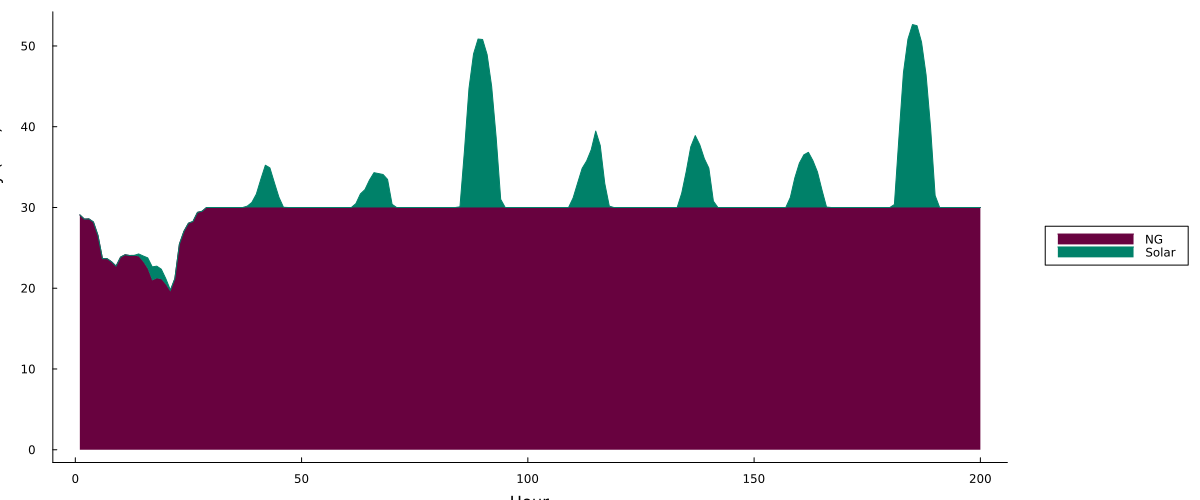

In [ ]:
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:outerright, legendcolumns=1)
plot!(p, size=(1200, 500))

In [28]:
@show value(sum(NSE));

value(sum(NSE)) = 256.83377442738583


In [312]:
sum(chp_price)

-5.0647000651435226e7

In [311]:
chp_price = @show shadow_price.(chp)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
   ⋮
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328
 -27.53453328

In [ ]:
elec_price = @show shadow_price.(chp)

shadow_price.(chp) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{Float64}:
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.

-1156.45039776

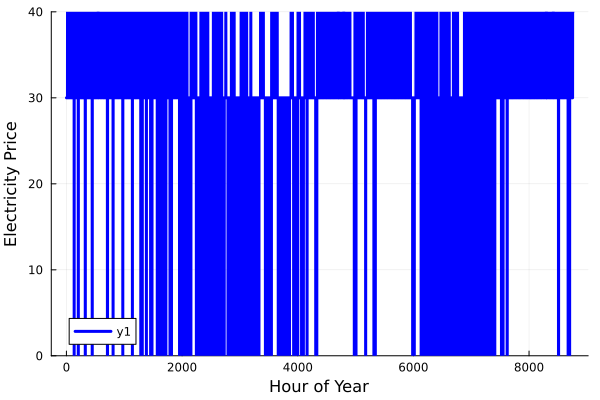

In [32]:
p = plot(; ylim = (0, 40), xlabel="Hour of Year", ylabel="Electricity Price")

# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -elec_price.data, linewidth=3, color=:blue)

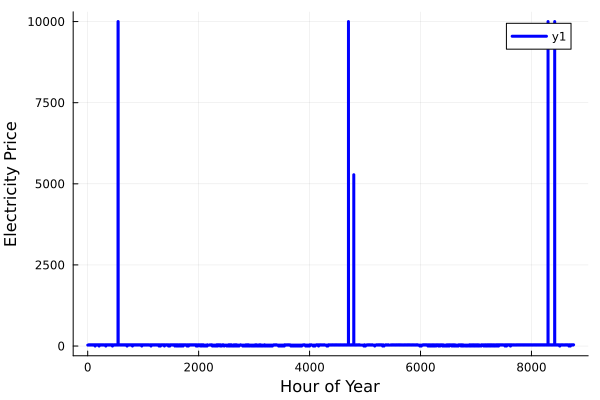

In [33]:
p = plot(; xlabel="Hour of Year", ylabel="Electricity Price")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -elec_price.data, linewidth=3, color=:blue)



### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

**In this problem**:

-   Reformulate your linear program from Problem 2 with any necessary
    changes to capture the CO<sub>2</sub> limit.
-   Implement the new optimization problem and find the optimal
    solution. How much should the utility build of each type of
    generating plant? What is different from your plan from Problem 1?
    Do these changes make sense?
-   What would the value to the utility be of allowing it to emit an
    additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

## References

List any external references consulted, including classmates.

https://penzai.readthedocs.io/en/v0.1.3/_autosummary/leaf/penzai.core.named_axes.NamedArray.html

https://dataframes.juliadata.org/stable/man/getting_started/

https://jump.dev/JuMP.jl/stable/manual/containers/#Access-internal-data